A Predictive Analysis of Heart Disease

We are using a data set from a Cleveland database with various measurements of variables correlated to heart disease, where a 1-4 indicates presence and 0 indicates absence in the num variable. Our goal is to create a predictive classifier that will allow us to take a set of values or measurements with an unknown class and predict whether or not it could indicate the development or presence of heart disease in an individual. The question we are looking to answer is ‘If we are given an observation with a set of unknown values, would we be able to create a classifier that can predict whether someone has/is at risk of developing heart disease or is healthy?' 
The data set that will be used to answer this question is the cleveland_data set; it has values for the following variables:

age: age in years
sex: sex(1 = male, 0 = female)
cp: chest pain type
-Value 1: typical angina
-Value 2: atypical angina
-Value 3: non-anginal pain
-Value 4: asymptomatic 
trestbps: resting blood pressure (in mm Hg on admission to the hospital)
chol: serum cholestoral in mg/dl 
fbs:(fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) 
restecg: resting electrocardiographic results
-Value 0: normal
-Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
-Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
thalach: maximum heart rate achieved
exang: exercise induced angina (1 = yes; 0 = no)
oldpeak = ST depression induced by exercise relative to rest
slope: the slope of the peak exercise ST segment
-Value 1: upsloping
-Value 2: flat
-Value 3: downsloping
ca: number of major vessels (0-3) colored by flourosopy
thal: 3 = normal; 6 = fixed defect; 7 = reversable defect 
num: diagnosis of heart disease (angiographic disease status)
-Value 0: < 50% diameter narrowing
-Value 1: > 50% diameter narrowing

Some of which will be used to help us make our predictive classifier. The names have been slightly altered within the classifier in order to make it more comprehensible. Although there are character equivalents to many of the numerical values used in this data set, as shown above, it will remain numerical throughout the report in order to create the classifier. These values will also be slightly altered when scaled. 

In [296]:
library(tidyverse)
library(tidymodels)
library(repr)
library(readxl)
options(repr.matrix.max.rows = 6)
library(GGally)
library(ISLR)

Here the appropriate libraries are loaded in order to create the visualizations, tables, classifier, etc. used within this report

In [2]:
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", destfile = "cleveland_data")

Our file of choice was downloaded from an external source as a comma separated values file and renamed cleveland_data for use within the Jupyter notebook. 

In [59]:
heart_disease_data <- read_delim("cleveland_data", col_names = FALSE, skip=20, delim= ",")
heart_disease_data

Rows: 283 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
64,1,1,110,211,0,2,144,1,1.8,2,0.0,3.0,0
58,0,1,150,283,1,2,162,0,1.0,1,0.0,3.0,0
58,1,2,120,284,0,2,160,0,1.8,2,0.0,3.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


Here is the the visualization of the data table that we just downloaded, the first 20 lines have been skipped to get to the true data set and the column names were set to false because they do not exist in this data set.

In [60]:
names(heart_disease_data) <- c("age", "sex", "chest_pain", "resting_bp", "cholesterol", "fasting_blood_sugar", "resting_electro", "max_hr", "ex_angina", "oldpeak", "slope", "ca", "thal", "num")
heart_disease_data <- heart_disease_data |>
mutate(num = case_when(num == 0 ~ "healthy" , num == 1 ~ "sick", num == 2 ~ "sick", num == 3 ~ "sick", num == 4 ~ "sick"))|>
mutate(num = as_factor(num))
heart_disease_data$ca[heart_disease_data$ca == "?"] <- NA
heart_disease_data$thal[heart_disease_data$thal == "?"] <- NA
heart_disease_data

age,sex,chest_pain,resting_bp,cholesterol,fasting_blood_sugar,resting_electro,max_hr,ex_angina,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
64,1,1,110,211,0,2,144,1,1.8,2,0.0,3.0,healthy
58,0,1,150,283,1,2,162,0,1.0,1,0.0,3.0,healthy
58,1,2,120,284,0,2,160,0,1.8,2,0.0,3.0,sick
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,sick
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,sick
38,1,3,138,175,0,0,173,0,0.0,1,NA,3.0,healthy


Here is where we added column names, in the order that they appeared as well as changing the class variable of "num" from a numerical value to a factor in order to prepare for the classification. Any variables with "?" as a value were also changed to "NA" in order to make it easier to remove later on.

In [61]:
heart_disease_data2 <- (na.omit(heart_disease_data))
heart_disease_data2

age,sex,chest_pain,resting_bp,cholesterol,fasting_blood_sugar,resting_electro,max_hr,ex_angina,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
64,1,1,110,211,0,2,144,1,1.8,2,0.0,3.0,healthy
58,0,1,150,283,1,2,162,0,1.0,1,0.0,3.0,healthy
58,1,2,120,284,0,2,160,0,1.8,2,0.0,3.0,sick
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,sick
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,sick
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,sick


In [ ]:
Here we removed all rows containing "NA" as a value so that classification is easier.

In [70]:
heart_disease_data3 <- heart_disease_data2|>
mutate(thal = as.numeric(thal))|>
mutate(ca = as.numeric(ca))

scaled_recipe_1 <- recipe(num ~ ., data = heart_disease_data3)|>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

heart_data_scaled_1 <- scaled_recipe_1 |>  
    prep() |> 
    bake(heart_disease_data3)
heart_data_scaled_1

age,sex,chest_pain,resting_bp,cholesterol,fasting_blood_sugar,resting_electro,max_hr,ex_angina,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1.034985,0.6981985,-2.248337,-1.1949675,-0.6930261,-0.4040717,1.001856,-0.2187793,1.415489,0.65826822,0.6868786,-0.7358115,-0.8929336,healthy
0.377437,-1.4270869,-2.248337,1.0317798,0.6730258,2.4658737,1.001856,0.5581676,-0.703919,-0.02561475,-0.9821159,-0.7358115,-0.8929336,healthy
0.377437,0.6981985,-1.212082,-0.6382806,0.6919987,-0.4040717,1.001856,0.4718402,-0.703919,0.65826822,0.6868786,-0.7358115,-0.8929336,sick
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1.4733496,0.6981985,0.8604283,0.69776774,-1.0345391,2.4658737,-1.009116,-0.3482704,-0.703919,2.0260342,0.6868786,1.3873112,1.1639696,sick
0.2678458,0.6981985,0.8604283,-0.08159381,-2.2108616,-0.4040717,-1.009116,-1.4705270,1.415489,0.1453560,0.6868786,0.3257499,1.1639696,sick
0.2678458,-1.4270869,-1.2120816,-0.08159381,-0.2187026,-0.4040717,1.001856,1.0761322,-0.703919,-0.8804685,0.6868786,0.3257499,-0.8929336,sick


Here all the variables were changed to numeric in order to allow it to be scaled and centered, once that was completed it was prepped which is used to save the processed data and baked in order to apply the saved recipe we created earlier to the data we want. 

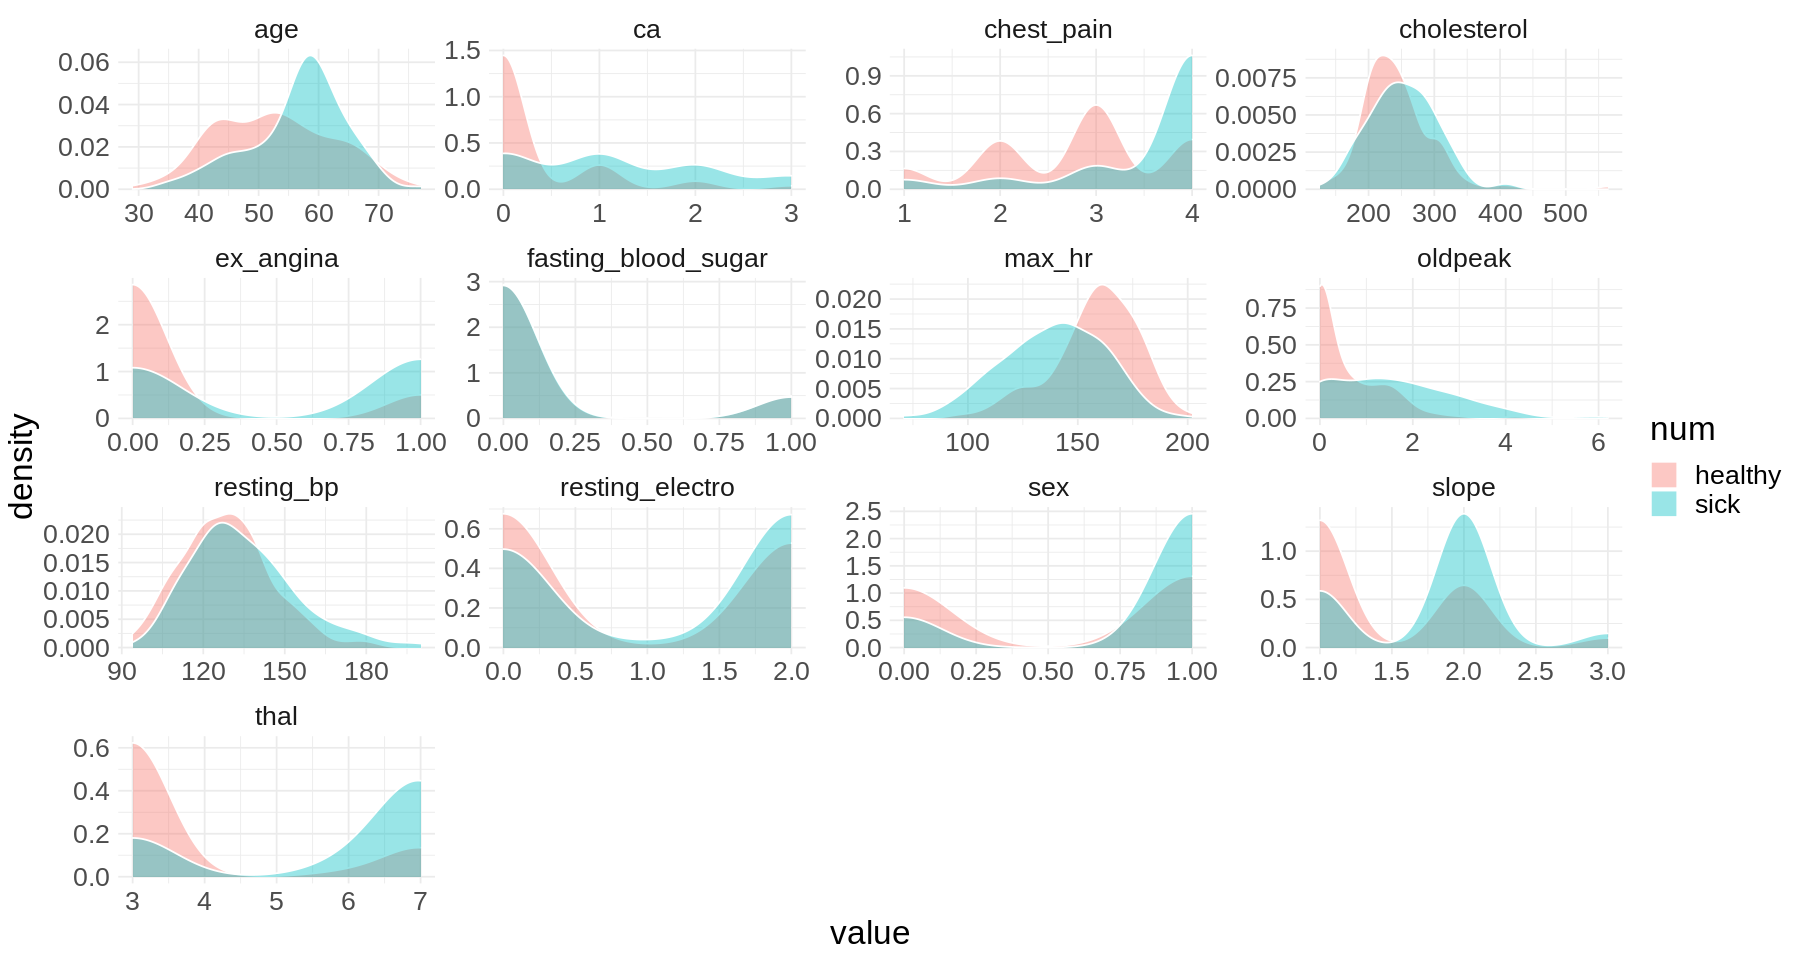

In [207]:
options(repr.plot.height = 8, repr.plot.width = 15)
heart_disease_data3|>
    pivot_longer(cols = -num, names_to = 'category', values_to = 'value')  |> 
    ggplot(aes(value, fill = num)) +
        geom_density(alpha = 0.4, colour = 'white') +
        facet_wrap(facets = vars(category), scales = 'free') +
        theme_minimal() +
        theme(text = element_text(size = 20))

In order to better identify the correlation between the variables in the data set and the diagnosis that was given.

In [264]:
heart_clean <- heart_data_scaled_1 |>
select("age", "sex", "oldpeak", "chest_pain", "thal", "max_hr", "ex_angina", "ca", "num")
heart_clean

age,sex,oldpeak,chest_pain,thal,max_hr,ex_angina,ca,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1.034985,0.6981985,0.65826822,-2.248337,-0.8929336,-0.2187793,1.415489,-0.7358115,healthy
0.377437,-1.4270869,-0.02561475,-2.248337,-0.8929336,0.5581676,-0.703919,-0.7358115,healthy
0.377437,0.6981985,0.65826822,-1.212082,-0.8929336,0.4718402,-0.703919,-0.7358115,sick
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1.4733496,0.6981985,2.0260342,0.8604283,1.1639696,-0.3482704,-0.703919,1.3873112,sick
0.2678458,0.6981985,0.1453560,0.8604283,1.1639696,-1.4705270,1.415489,0.3257499,sick
0.2678458,-1.4270869,-0.8804685,-1.2120816,-0.8929336,1.0761322,-0.703919,0.3257499,sick


In [265]:
heart_disease_split <- initial_split(heart_clean, prop = 0.75, strata = num)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)

In [266]:
heart_disease_table <- heart_disease_train |>
group_by(num)|>
summarize(chest_pain = mean(chest_pain, na.rm = TRUE),
    thal = mean(thal, na.rm = TRUE),
    ex_angina = mean(ex_angina, na.rm = TRUE),
    oldpeak = mean(oldpeak, na.rm = TRUE),
    sex = mean(sex, na.rm = TRUE),
    ca = mean(ca, na.rm = TRUE),
    age = mean(age, na.rm = TRUE),
    max_hr = mean(max_hr, na.rm = TRUE))
heart_disease_table

num,chest_pain,thal,ex_angina,oldpeak,sex,ca,age,max_hr
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
healthy,-0.3924982,-0.5142764,-0.3956414,-0.4235103,-0.3644442,-0.3883914,-0.2053892,0.3984619
sick,0.4117406,0.5225127,0.4104091,0.3630352,0.3476359,0.5008528,0.2542881,-0.3602850


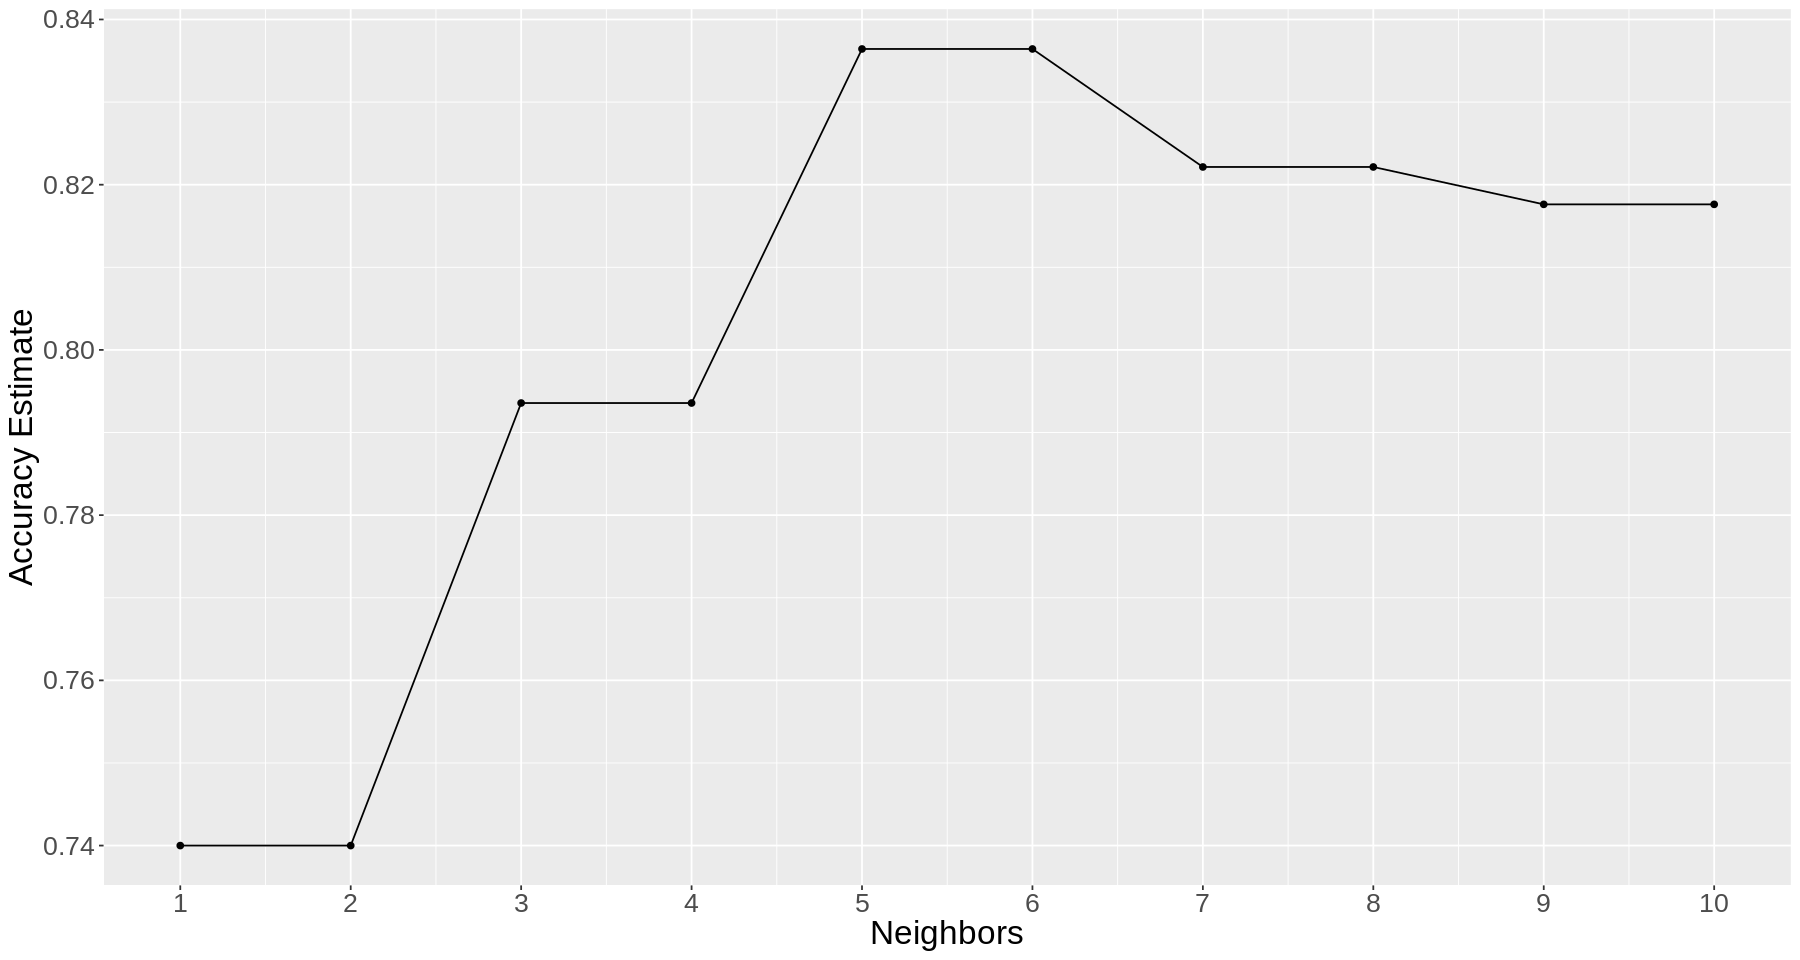

In [267]:
set.seed(2019) 

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

training_recipe <- recipe(num ~ ., data = heart_disease_train)

training_vfold <- vfold_cv(heart_disease_train, v = 10, strata = num)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 4) |>
    set_engine("kknn") |>
    set_mode("classification")

training_resample_fit <- workflow() |>
    add_recipe(training_recipe) |>
    add_model(knn_spec) |>
    fit_resamples(resamples = training_vfold)

grid_frame <- tibble(neighbors = (c(1,2,3,4,5,6,7,8,9,10)))

knn_results <- workflow() |>
    add_recipe(training_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = training_vfold, grid = grid_frame) |>
    collect_metrics()

accuracies <- knn_results |> 
    filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 10, by = 1))+
    theme(text = element_text(size = 20))
cross_val_plot

In [274]:
set.seed(2019) 

heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_fit <- workflow() |>
    add_recipe(training_recipe) |>
    add_model(heart_spec) |>
    fit(data = heart_disease_train)
heart_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(5,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1835749
Best kernel: rectangular
Best k: 5

In [275]:
set.seed(2019) 

heart_predictions <- predict(heart_fit , heart_disease_test) |>
    bind_cols(heart_disease_test)
heart_predictions

heart_metrics <- heart_predictions |>
    metrics(truth = num, estimate = .pred_class)             
heart_metrics

heart_conf_mat <- heart_predictions |> 
    conf_mat(truth = num, estimate = .pred_class)
heart_conf_mat

.pred_class,age,sex,oldpeak,chest_pain,thal,max_hr,ex_angina,ca,num
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
healthy,-1.1568406,0.6981985,-0.53852698,-0.1758267,-0.8929336,1.2919508,1.415489,-0.7358115,healthy
healthy,-1.3760231,0.6981985,-0.88046846,0.8604283,-0.8929336,1.2487870,-0.703919,-0.7358115,healthy
healthy,0.7062108,0.6981985,-0.02561475,-0.1758267,-0.8929336,-0.5209253,1.415489,-0.7358115,healthy
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
sick,0.4870283,0.6981985,-0.02561475,0.8604283,0.6497438,-2.549620,-0.703919,1.3873112,sick
sick,0.2678458,0.6981985,0.14535599,0.8604283,1.1639696,-1.470527,1.415489,0.3257499,sick
healthy,0.2678458,-1.4270869,-0.88046846,-1.2120816,-0.8929336,1.076132,-0.703919,0.3257499,sick


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8285714
kap,binary,0.6593674


          Truth
Prediction healthy sick
   healthy      28    3
   sick          9   30

In [276]:
heart_proportions <- heart_disease_train |>
group_by(num) |>
summarize(n = n()) |>
mutate(percent = 100*n/nrow(heart_disease_train))
heart_proportions

num,n,percent
<fct>,<int>,<dbl>
healthy,110,53.1401
sick,97,46.8599


In [411]:
conf <- structure(c(28, 9, 3, 30, 0.243243243, 0.09090909
), .Dim = 2:3, .Dimnames = list(c("Healthy_p", "Sick_p"), c("Healthy", 
"Sick", "class.error")))
conf

,Healthy,Sick,class.error
Healthy_p,28,3,0.24324324
Sick_p,9,30,0.09090909


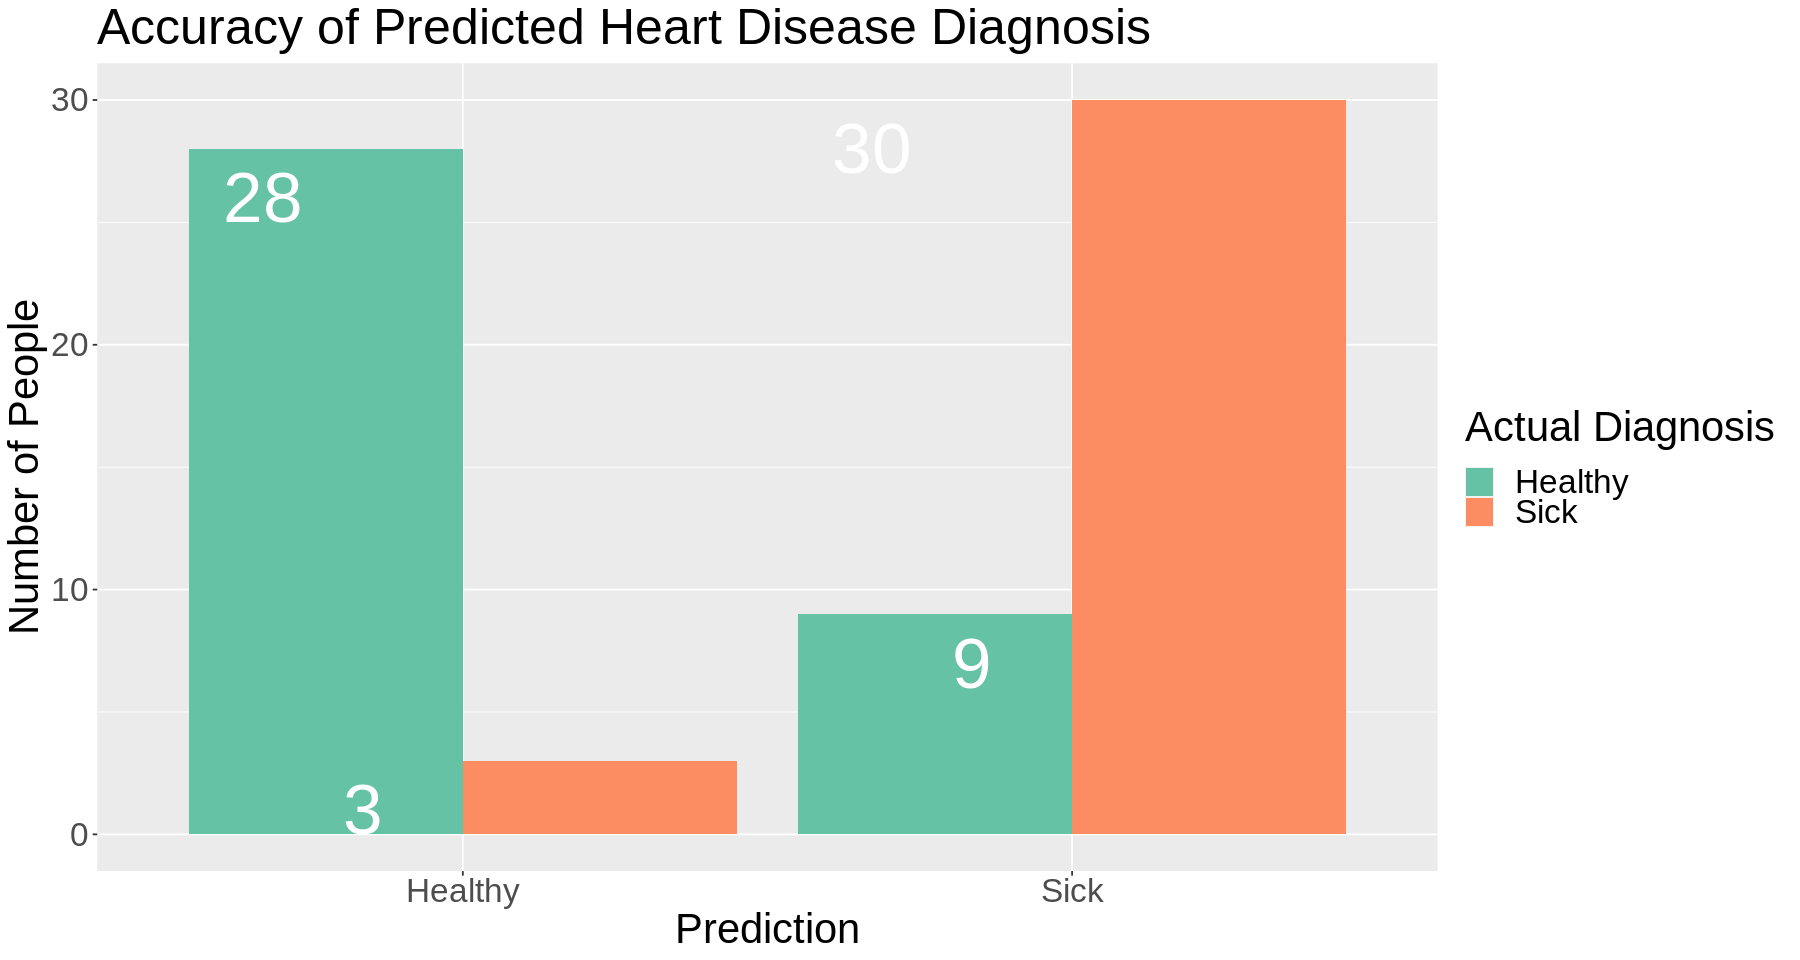

In [467]:
conf_plot <- conf|> 
as.data.frame(conf) |>
select(-class.error)|>
tibble::rownames_to_column("Prediction")|>
mutate(Prediction = case_when(Prediction == 1 ~ "Healthy" , Prediction == 2 ~ "Sick"))|>
pivot_longer(-Prediction, names_to = "Diagnosis")|>
ggplot((aes(x=Prediction,y=value,fill=Diagnosis))) + geom_bar(stat = "identity", position = "dodge") +
ylab("Number of People") +
xlab("Prediction") +
labs(fill = "Actual Diagnosis") +
ggtitle("Accuracy of Predicted Heart Disease Diagnosis") +
scale_fill_brewer(palette = "Set2") +
#geom_text(aes(label = value), vjust = 1.5, size = 15, color = "white", hjust = 3) + #can't figure out how to center the labels 
theme(text = element_text(size = 25))
print(conf_plot)